# Imports

In [2]:
# to import from the parent directories
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

# libraries used
import torch
import torch.nn as nn
import numpy as np
import json
import pandas as pd
import random
import matplotlib.pyplot as plt

# our functions
import agent
from toolbox import mkdir, model_best_acc_detector, load_numpy, UniversalConstants, UniversalData, load_listener_model, load_data, imgn_per_x_objn, dict_to_batches, make_vocabulary, make_index_table, get_word_ix, make_ix_to_word, logit_word_ix_map, logit_mean, logit_catch_in_one_batch, logit_dict_making, load_val_batch_analysis

# Frequency Influence Analysis

In this analysis notebook we are going through these levels and tasks:

1. [Defining Constants and reading Data](#data)
2. [Load the most accurate listener model](#load)
    1. [Find the most accurate model](#best)
    2. [Load it](#load_it)
Load the Model
2. Make dataframe to keep logits
3. Extract Logits and save them into df
4. Take the mean
5. Make the plot

## Doc
Here comes a short documentation of what is going on:

### Variables
* `validation_data`:
    is a `list` of len `1000`, containing the id of images
* `no_objs_val`:
* `val_batchlist`:
* `path_dict_words_boxes`:

## Defining Constants and reading Data <a name="data"></a>

### Global Constants

In [10]:
uc = UniversalConstants()
ud = UniversalData()

device = ud.device

path_models = os.path.join(parent_dir, 'outfiles', 'models')


#random.seed(a=seed)

# setting torch seeds
#torch.cuda.manual_seed(seed)
#torch.manual_seed(seed)

#np.random.seed(seed)

In [4]:
#here_agent = listener
setting = 'curious'
which_set = 'train'

### Data

As we need to analyze the behaviour of the models on Validation, here we read the data about it.

In [5]:
ha_vggs_indices = load_data(os.path.join(uc.paths['data'], "ha_vgg_indices.json"))

dict_words_boxes = load_data(os.path.join(uc.paths['data'], "dict_words_boxes.json"))
print("dict_words_boxes type:\t", type(dict_words_boxes), "\ndict_words_boxes len:\t", len(dict_words_boxes))

vocab, freq = make_vocabulary(dict_words_boxes)  # Makes a vocabulary of the entire set of objects
word_to_ix = make_index_table(vocab)  # Gives an index number to every word in the vocabulary todo: change name to
# indexed_vocabulary

ix_to_word_df = make_ix_to_word(word_to_ix)

dict_words_boxes type:	 <class 'dict'> 
dict_words_boxes len:	 24670


#### Validation Data

In [6]:
validation_data = load_data(os.path.join(uc.paths['data'], "train_data.txt"))
print("validation_data type:\t", type(validation_data), "\nvalidation_data len:\t", len(validation_data))

validation_data type:	 <class 'list'> 
validation_data len:	 22670


In [7]:
no_objs_val = imgn_per_x_objn(dict_words_boxes, validation_data)

# making validation batchlist
val_batchlist = dict_to_batches(no_objs_val, uc.batchsize_default)

## Find and Load the most Accurate model <a name="load"></a>

### Find the most accurate epochs in models <a name="find"></a>

In [8]:
path_loss_acc = os.path.join(parent_dir, 'loss_acc/')

best = model_best_acc_detector(path_loss_acc, 'listener', setting, which_set, uc.final_seeds)

### Load the model <a name="loadit"></a>

In [12]:
listener = load_listener_model(path_models, ud.indexed_vocab,device, setting, best['best_ep'], 0.001, best['best_seed'])

Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------



In [198]:
result = logit_mean(listener, val_batchlist, freq, dict_words_boxes, word_to_ix, ix_to_word_df, uc.paths['data'], device)

In [205]:
def fa_sort_on_freq(_logit_mean_result):
    results_without_logit_list = logit_dict_making(_logit_mean_result, False)
    result_df = pd.DataFrame.from_dict(results_without_logit_list, orient='index')
    result_df = result_df.reset_index()
    result_df = result_df.rename(columns={"index": 'word', 0: 'index'})
    return result_df.sort_values(by='freq', ascending=False)

In [206]:
sorted_on_freq = fa_sort_on_freq(result)

### Save to CSV

In [207]:
mkdir('frequency_analysis')
_path_save_csv = os.path.join('frequency_analysis', 'freq_{}_table.csv'.format(setting))
sorted_on_freq.to_csv(_path_save_csv , sep='\t',header=True, index=None, encoding='utf-8')

## Plot The Result <a name="plot"></a>

In [208]:
sorted_on_freq['difference'] = (sorted_on_freq['match']-sorted_on_freq['not_match'])
rdf = sorted_on_freq

In [209]:
rdf[rdf['difference'] != 0].shape

(4074, 5)

In [210]:
rdf_without_zero = rdf[rdf['difference'] != 0]
# rdf_without_zero

(0, 100)

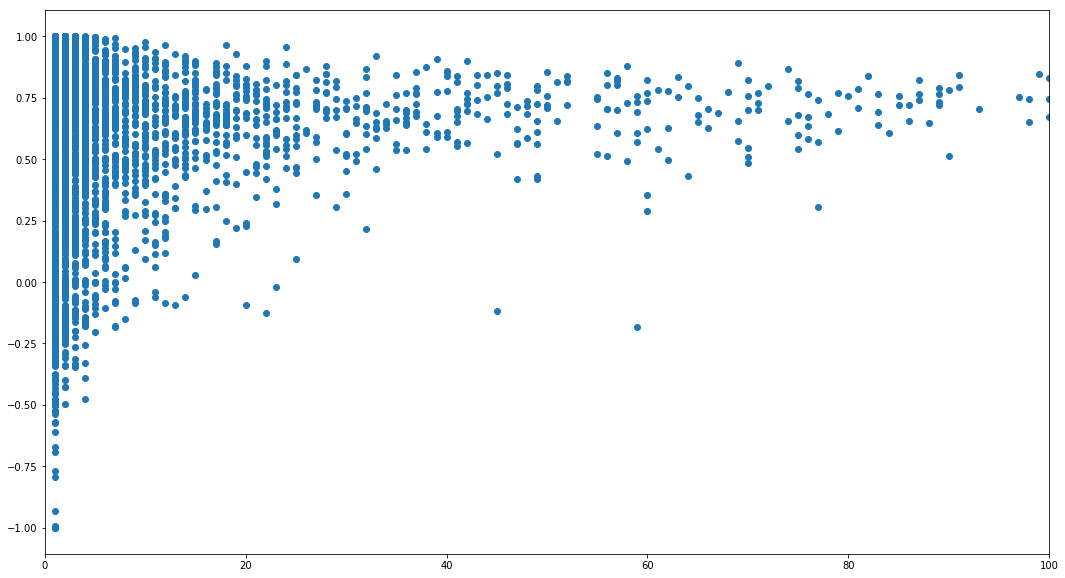

In [220]:
plt.figure(figsize=(18,10))
plt.scatter(rdf_without_zero.freq, rdf_without_zero.difference)
plt.xlim(0,100)
# plt.ylim(-0.0000000000000000000000000001, 0.0000000000000000000000000001)

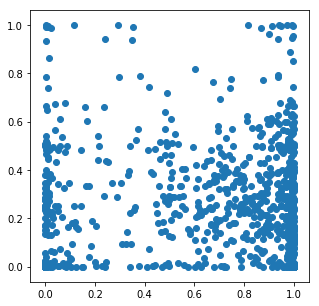

In [171]:
plt.figure(figsize=(5,5))
plt.scatter(rdf_without_zero.match, rdf_without_zero.not_match)
# plt.xlim(0,100)